In [4]:
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.engine import training
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras import Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Average
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from scipy import stats
from statistics import mean
from keras.models import load_model

In [5]:

BATCH_SIZE = 8

train_generator = ImageDataGenerator(rescale=1./255) 

val_generator = ImageDataGenerator(rescale=1./255)

test_generator = ImageDataGenerator(rescale=1./255)


In [6]:
train_data_dir = '../data_splits/train'
val_data_dir = '../data_splits/val'
test_data_dir = '../data_splits/test'




traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,
                                               subset='training',
                                               seed=42)

validgen = val_generator.flow_from_directory(val_data_dir,
                                             target_size=(224, 224),
                                             batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             batch_size=BATCH_SIZE,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)


Found 151 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


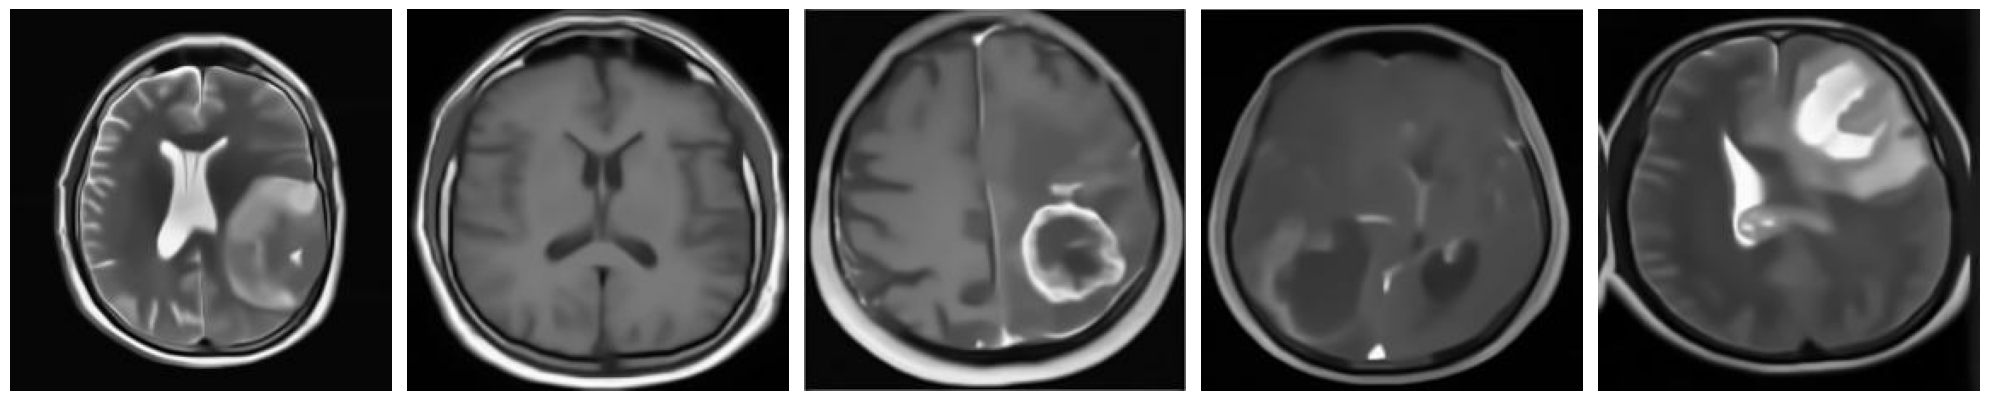

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [7]:
import matplotlib.pyplot as plt
sample_training_images, labels = next(traingen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])
print(labels)

In [8]:
input_shape = (224, 224, 3)
optimizer = Adam(learning_rate=0.001)
n_classes= len(traingen.class_indices)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100
model_input = Input(shape=input_shape)

# MobileNet

In [9]:
def mobilenet(model_input: Tensor, optimizer) -> training.Model:
    conv_base = MobileNetV2(include_top = False,
                weights = 'imagenet',
                input_shape = input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = Flatten()(conv_base.output)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1000, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs = conv_base.input, outputs= output_layer, name='mobilenet_model')
    model.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model

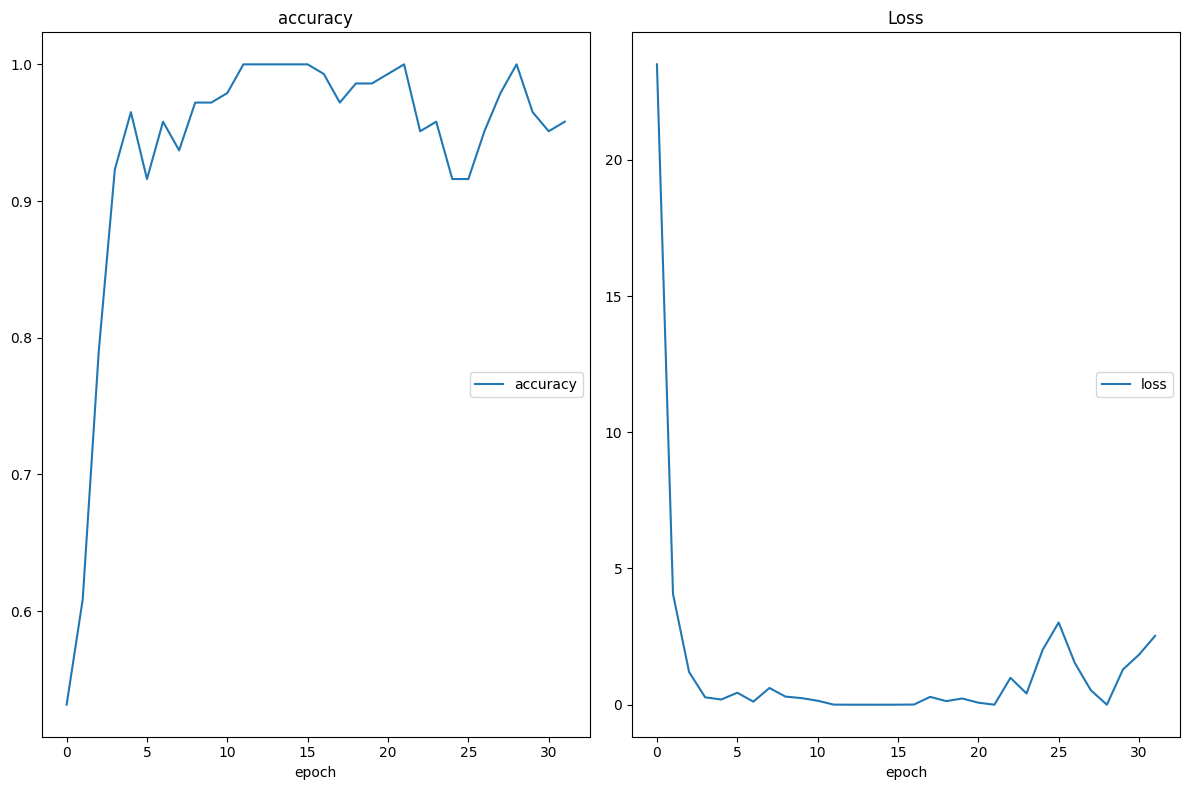

accuracy
	accuracy         	 (min:    0.531, max:    1.000, cur:    0.958)
Loss
	loss             	 (min:    0.000, max:   23.505, cur:    2.526)
18/18 [==============================] - 51s 3s/step - loss: 2.5262 - accuracy: 0.9580


In [10]:
mobilenet_model = mobilenet(model_input, optimizer)
plot_loss_mobilenet = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_mobilenet = ModelCheckpoint(filepath='tl_model_nonprocessed_mobilenet_dnn.weights.best.hdf5',
                                      monitor='loss',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                        patience=10,
                        restore_best_weights=True,
                        mode='min')

mobilenet_history = mobilenet_model.fit(traingen,
        batch_size=BATCH_SIZE,
        epochs= n_epochs,
        shuffle= True,
        steps_per_epoch=n_steps,
        callbacks=[tl_checkpoint_mobilenet, early_stop, plot_loss_mobilenet],
        verbose=1)